<h1><bold>
Atelier 2: Moteur de Recherche d'images par le contenu Approche classique - Descripteurs Locaux </bold>

----
<h2>1	Introduction</h2>

Le but ici est d’extraire un vecteur de caractéristiques *local* par image, et d’utiliser une métrique associée pour le calcul des similarités entre images. Pour cela, on construit un vecteur de caractéristique basé sur les *points d'intérêt* des images. Ceci devra aboutir à la génération d'une
*matrice de distances* ou de *similarité* entre toutes les images (matrices NxN, où N est le nombre d'images), et sera validée par la visualisation des images les plus proches d'une image requete donnée.
Nous comparerons ensuite la robustesse de l'approche locale face aux transformations géométriques et photométriques.

## Lecture des images
Pour se faire, on commence par extraire la liste des images en question

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import glob
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_base = '/content/drive/MyDrive/bibimage/BE'
image_paths = sorted(glob.glob(os.path.join(path_base, "*.jpg")) +
                     glob.glob(os.path.join(path_base, "*.png")) +
                     glob.glob(os.path.join(path_base, "*.jpeg")))

print(f"{len(image_paths)} images trouvées.")

50 images trouvées.


## Construction d'un vecteur caractéristique par image
Pour chaque image, l'objectif ici est de déterminer les points d'intérêt par le détecteur de Harris, et de calculer le descripteur SIFT pour chaque point d'intérêt. Un **descripteur SIFT** correspond à un **vecteur** de taille **128**.

D'où, le vecteur de caractéristique = concaténation des descripteurs.

Une image sera alors décrite par: un vecteur de taille 128 * nbre de points d'intérêt détectés.

### Points d’intérêts en utilisant les détecteurs de **Harris** et **SIFT**.
Harris détecte les coins saillants, utiles pour localiser des points d’intérêt (ceux riches en information visuelle).
SIFT fournit des descripteurs invariants à la rotation et à l’échelle, robustes aux transformations.
Ainsi, la comparaison se base sur des parties “distinctives” de l’image

100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Nombre de points d'intérêt détectés pour 01.jpg: 175
Taille du descripteur pour 01.jpg: (175, 128)


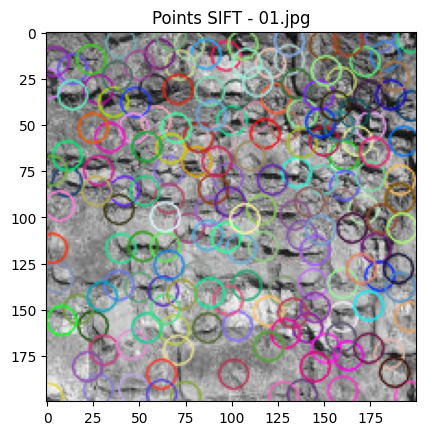

In [4]:
def harris_keypoints(img_gray, max_corners=500, quality=0.01, min_dist=10):
    # img_gray: uint8 or float [0..255]
    corners = cv2.goodFeaturesToTrack(img_gray, maxCorners=max_corners, qualityLevel=quality, minDistance=min_dist, useHarrisDetector=True, k=0.04)
    keypoints = []
    if corners is None:
        return keypoints
    for c in corners:
        x, y = c.ravel()
        keypoints.append(cv2.KeyPoint(x=float(x), y=float(y), size=16))
    return keypoints

def compute_sift_descriptors(img_gray, keypoints=None):
    sift = cv2.SIFT_create()
    if keypoints is None:
        kp = sift.detect(img_gray, None)
        kp, descriptors = sift.compute(img_gray, kp)
    else:
        kp, descriptors = sift.compute(img_gray, keypoints)
    return kp, descriptors  # descriptors: Nx128 or None

# Store keypoints and descriptors for each image
keypoints_images = {}
descriptors_images = {}

for path in tqdm(image_paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    keypoints = harris_keypoints(img)
    keypoints, descriptors = compute_sift_descriptors(img, keypoints)
    keypoints_images[path] = keypoints
    descriptors_images[path] = descriptors

# Display keypoints for the first image as an example
if len(image_paths) > 0:
    img_test_path = image_paths[0]
    img_test = cv2.imread(img_test_path, cv2.IMREAD_GRAYSCALE)
    keypoints_test = keypoints_images.get(img_test_path, [])
    descriptors_test = descriptors_images.get(img_test_path, None)

    print(f"Nombre de points d'intérêt détectés pour {os.path.basename(img_test_path)}: {len(keypoints_test)}")
    if descriptors_test is not None:
        print(f"Taille du descripteur pour {os.path.basename(img_test_path)}: {descriptors_test.shape}")
    else:
        print(f"Aucun descripteur calculé pour {os.path.basename(img_test_path)}")


    img_test_keypoints = cv2.drawKeypoints(img_test, keypoints_test, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_test_keypoints, cmap='gray') # Pass the image data to imshow
    plt.title(f"Points SIFT - {os.path.basename(img_test_path)}") # Corrected title
    plt.show()
else:
    print("No images found to process.")

### Points d’intérêts en utilisant le descripteur **invariant différentiel** (Hu Moments)

Sert à capturer la forme globale de l’objet qui reste stable indépendamment de la position ou de la rotation légère (invariant), contrairement à SIFT.

In [5]:
def invariant_features(img_gray):
    moments = cv2.moments(img_gray)
    hu = cv2.HuMoments(moments).flatten()
    return -np.sign(hu)*np.log10(np.abs(hu)+1e-10)

hu_features = {}
for path in tqdm(image_paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    hu_features[path] = invariant_features(img)

hu_features_test = hu_features.get(img_test_path, None)
if hu_features_test is not None:
    print(f"\nDescripteurs Hu pour {os.path.basename(img_test_path)}:")
    print(hu_features_test)
else:
    print(f"Aucun descripteur Hu calculé pour {os.path.basename(img_test_path)}")

100%|██████████| 50/50 [00:00<00:00, 114.21it/s]


Descripteurs Hu pour 01.jpg:
[  2.94790164   9.62614113   9.95705136   9.98846355  10.
  -9.99999987 -10.        ]


Le vecteur descripteur Hu de l'image est un vecteur de 7 nombres réels, correspondant aux *7 moments invariants de Hu* transformés logarithmiquement de l'image. Ces valeurs indiquent des invariances géométriques (mais ne renseignent pas des significations visuelles comme les formes)
Deux images “visuellement similaires” devraient avoir des vecteurs Hu proches numériquement.



> Hu a montré qu’à partir des moments d’ordre 2 et 3 d’une image, on pouvait construire 7 combinaisons particulières de ces moments qui restent invariantes aux transformations.



### Stockage des résultats avant augmentation des données

In [ ]:
combined_data = []
for path in image_paths:
    descriptors = descriptors_images.get(path)
    keypoints = keypoints_images.get(path)
    hu_features_img = hu_features.get(path)

    if descriptors is not None and keypoints is not None and hu_features_img is not None:
        for i, desc in enumerate(descriptors):
            kp = keypoints[i]
            combined_data.append({
                'image_path': path,
                'keypoint_x': kp.pt[0],
                'keypoint_y': kp.pt[1],
                'descriptor': desc.tolist(), # Convert numpy array to list
                'hu_moments': hu_features_img.tolist() # Add Hu Moments to each SIFT row
            })

combined_df = pd.DataFrame(combined_data)
combined_csv_path = '/content/drive/MyDrive/descriptors_before_augmentation.csv'
combined_df.to_csv(combined_csv_path, index=False)
print(f"Combined SIFT and Hu Moments features saved to: {combined_csv_path}")

Combined SIFT and Hu Moments features saved to: /content/drive/MyDrive/descriptors_before_augmentation.csv


In [ ]:
combined_df.head()

,image_path,keypoint_x,keypoint_y,descriptor,hu_moments
0,/content/drive/MyDrive/bibimage/BE/01.jpg,175.0,51.0,"[51.0, 20.0, 16.0, 17.0, 43.0, 29.0, 11.0, 19....","[2.947901639876876, 9.626141134574015, 9.95705..."
1,/content/drive/MyDrive/bibimage/BE/01.jpg,129.0,51.0,"[18.0, 40.0, 41.0, 11.0, 17.0, 42.0, 91.0, 22....","[2.947901639876876, 9.626141134574015, 9.95705..."
2,/content/drive/MyDrive/bibimage/BE/01.jpg,178.0,117.0,"[22.0, 68.0, 61.0, 22.0, 24.0, 47.0, 76.0, 19....","[2.947901639876876, 9.626141134574015, 9.95705..."
3,/content/drive/MyDrive/bibimage/BE/01.jpg,97.0,13.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.947901639876876, 9.626141134574015, 9.95705..."
4,/content/drive/MyDrive/bibimage/BE/01.jpg,106.0,7.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.947901639876876, 9.626141134574015, 9.95705..."


### Augmentation de la base d’images en appliquant différents types de transformations (rotation, translation, zoom, contraste, etc).

In [8]:
AUG_DIR = '/content/drive/MyDrive/bibimage/augmented'

def augment_image(img):
    rows, cols = img.shape[:2]
    augmented_images = []

    # Rotation + zoom
    M_rot_zoom = cv2.getRotationMatrix2D((cols//2, rows//2), 15, 1.2)
    img_aug_rot_zoom = cv2.warpAffine(img, M_rot_zoom, (cols, rows))
    augmented_images.append(img_aug_rot_zoom)

    # Contraste
    img_aug_contrast = cv2.convertScaleAbs(img, alpha=0.8, beta=20)
    augmented_images.append(img_aug_contrast)

    # Translation
    M_trans = np.float32([[1,0,15],[0,1,10]]) # Increased translation for visibility
    img_aug_trans = cv2.warpAffine(img, M_trans, (cols, rows))
    augmented_images.append(img_aug_trans)

    return augmented_images

def build_augmented_db(image_paths):
    augmented_paths = []
    # Create the augmentation directory if it doesn't exist
    if not os.path.exists(AUG_DIR):
        os.makedirs(AUG_DIR)

    for path in tqdm(image_paths, desc="Augmenting images"):
        img = cv2.imread(path)
        if img is None: continue
        base = os.path.splitext(os.path.basename(path))[0]
        aug_imgs = augment_image(img)
        for i, aug in enumerate(aug_imgs):
            # Ensure the augmented image is not None and has data before saving
            if aug is not None and aug.size > 0:
                out_path = os.path.join(AUG_DIR, f"{base}_aug{i}.jpg")
                cv2.imwrite(out_path, aug)
                augmented_paths.append(out_path)
    return augmented_paths

augmented_paths = build_augmented_db(image_paths)
print(f"\nGenerated {len(augmented_paths)} augmented images.")

Augmenting images: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]


Generated 150 augmented images.


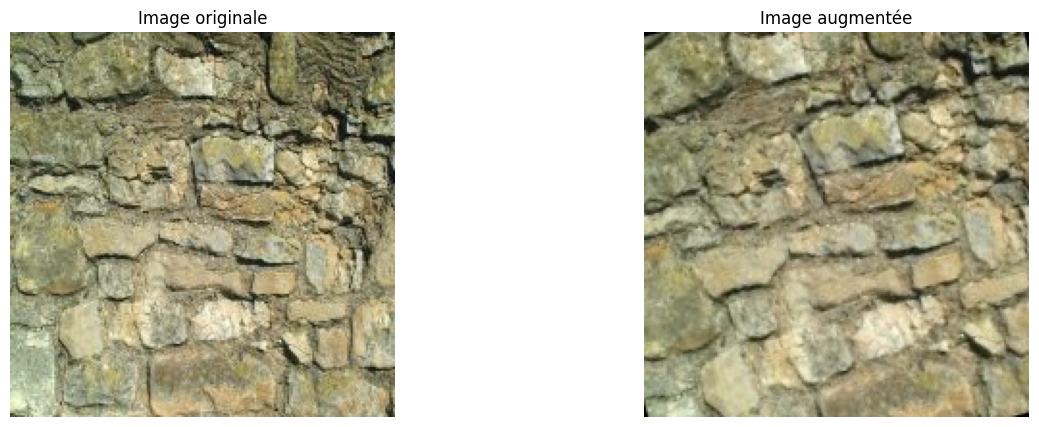

In [ ]:
img0 = cv2.imread(os.path.join(image_paths[0]))
img0_aug = cv2.imread(os.path.join(augmented_paths[0]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
if img0 is not None:
    plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
    plt.title("Image originale")
    plt.axis('off')
else:
    plt.title("Could not load original image")

plt.subplot(1,2,2)
if img0_aug is not None:
    plt.imshow(cv2.cvtColor(img0_aug, cv2.COLOR_BGR2RGB))
    plt.title("Image augmentée")
    plt.axis('off')
else:
    plt.title("Could not load augmented image")

plt.show()

### **Calcul des matrices de similarités**

In [16]:
def compute_similarity(desA, desB):
    """
    Calcule la similarité entre deux ensembles de descripteurs SIFT (desA et desB).

    Args:
        desA: numpy array de taille (n1, 128)
        desB: numpy array de taille (n2, 128)

    Returns:
        similarity: int — nombre de correspondances réciproques
    """
    # Cas où une image n’a pas de points d’intérêt
    if desA is None or desB is None or len(desA) == 0 or len(desB) == 0:
        return 0

    # Normalisation des descripteurs (chaque vecteur à norme 1)
    desA = desA / np.linalg.norm(desA, axis=1, keepdims=True)
    desB = desB / np.linalg.norm(desB, axis=1, keepdims=True)

    # Calcul des distances L2 (n1 x n2)
    distances = np.linalg.norm(desA[:, None, :] - desB[None, :, :], axis=2)

    # Pour chaque descripteur de A → index du plus proche de B
    A_to_B = np.argmin(distances, axis=1)
    # Pour chaque descripteur de B → index du plus proche de A
    B_to_A = np.argmin(distances, axis=0)

    # Couples réciproques : (Ai -> Bj) ET (Bj -> Ai)
    reciprocal_matches = [
        (i, j)
        for i, j in enumerate(A_to_B)
        if B_to_A[j] == i
    ]

    similarity = len(reciprocal_matches)
    return similarity

In [22]:
def compute_similarity_matrix(descriptor):
  N = len(image_paths)
  S = np.zeros((N, N), dtype=np.float32)

  for i in range(N):
      for j in range(i, N):  # Symétrique
          sim = compute_similarity(descriptor[image_paths[i]], descriptor[image_paths[j]])
          S[i, j] = sim
          S[j, i] = sim
  return S

def compute_hu_similarity_matrix(hu_features):
    """
    Calcule la matrice de similarité entre images basée sur les moments de Hu.
    """
    image_paths_list = list(hu_features.keys())
    N = len(image_paths_list)
    S_hu = np.zeros((N, N), dtype=np.float32)

    for i in range(N):
        for j in range(i, N):
            # Calcul de la distance Euclidienne entre les moments de Hu
            dist = np.linalg.norm(hu_features[image_paths_list[i]] - hu_features[image_paths_list[j]])
            # Convertir la distance en similarité (petite distance = grande similarité)
            # Utiliser une fonction exponentielle inverse ou simplement 1 / (1 + dist)
            sim = 1 / (1 + dist) # Adding a small constant to avoid division by zero is not needed here since dist >= 0
            S_hu[i, j] = sim
            S_hu[j, i] = sim

    return S_hu

def normalize_similarity_matrix(S):
    N = S.shape[0]
    P = np.zeros_like(S)
    for i in range(N):
        for j in range(N):
            denom = min(S[i, i], S[j, j]) if min(S[i, i], S[j, j]) > 0 else 1
            P[i, j] = S[i, j] / denom
    np.fill_diagonal(P, 1)
    return P

In [29]:
def show_similar_images(P, image_paths, query_index,message, top_k=5):
    plt.figure(figsize=(15, 4))
    plt.title("Similarité des images "+message)

    # Image requête
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(cv2.imread(image_paths[query_index])[:, :, ::-1])
    plt.title("Image requête")
    plt.axis("off")

    # Tri des similarités décroissantes
    similarities = P[query_index]
    sorted_idx = np.argsort(-similarities)

    for rank, idx in enumerate(sorted_idx[1:top_k+1]):
        plt.subplot(1, top_k + 1, rank + 2)
        plt.imshow(cv2.imread(image_paths[idx])[:, :, ::-1])
        plt.title(f"Sim={similarities[idx]:.2f}")
        plt.axis("off")

    plt.show()

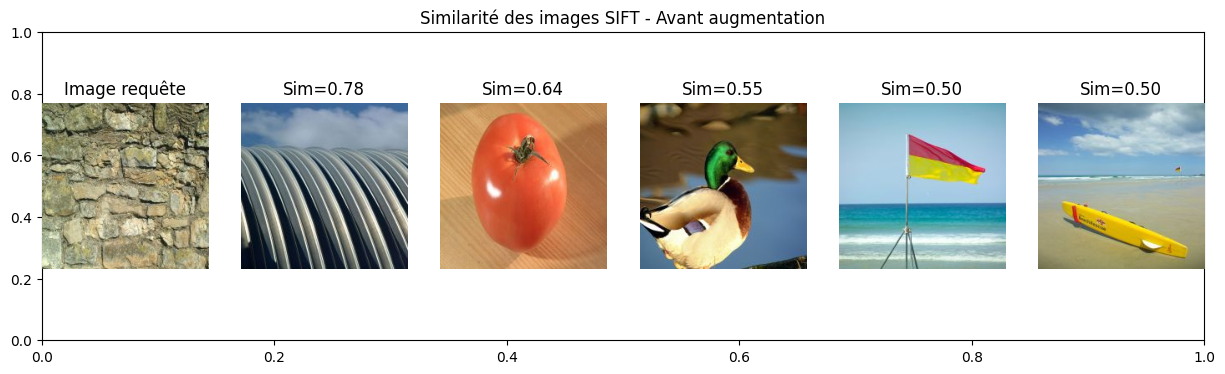

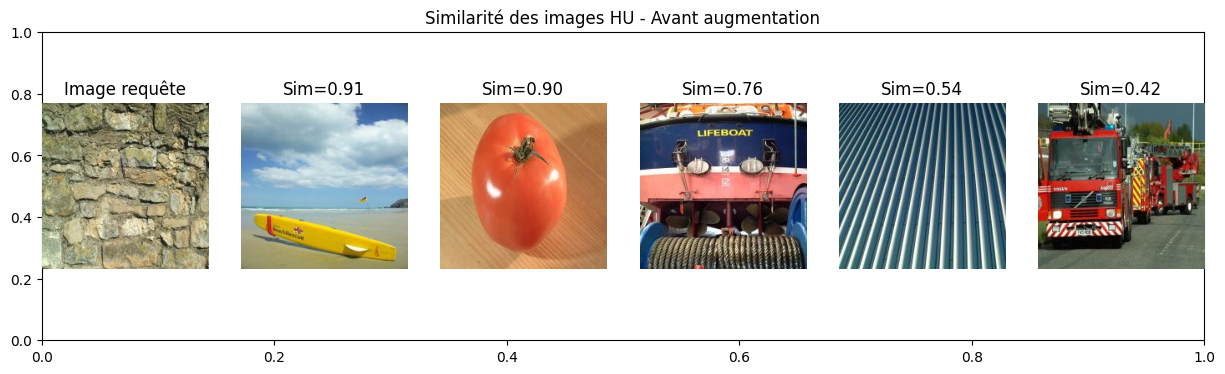

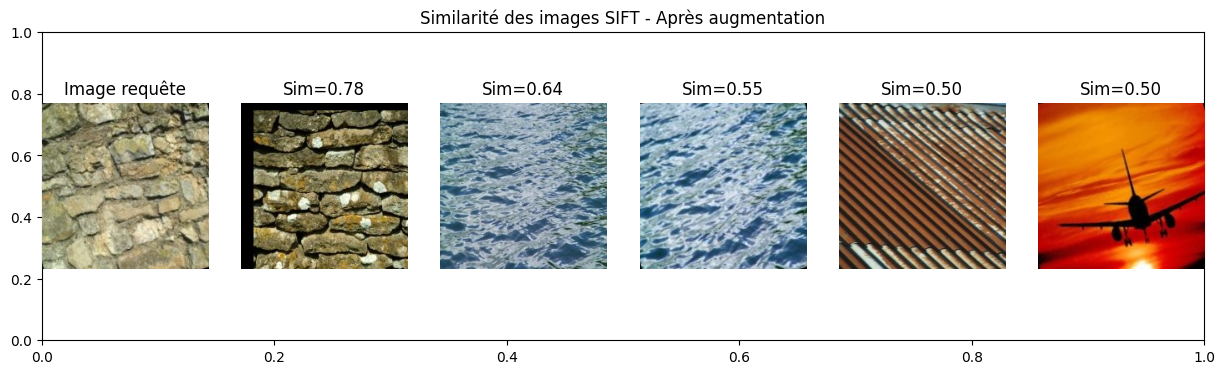

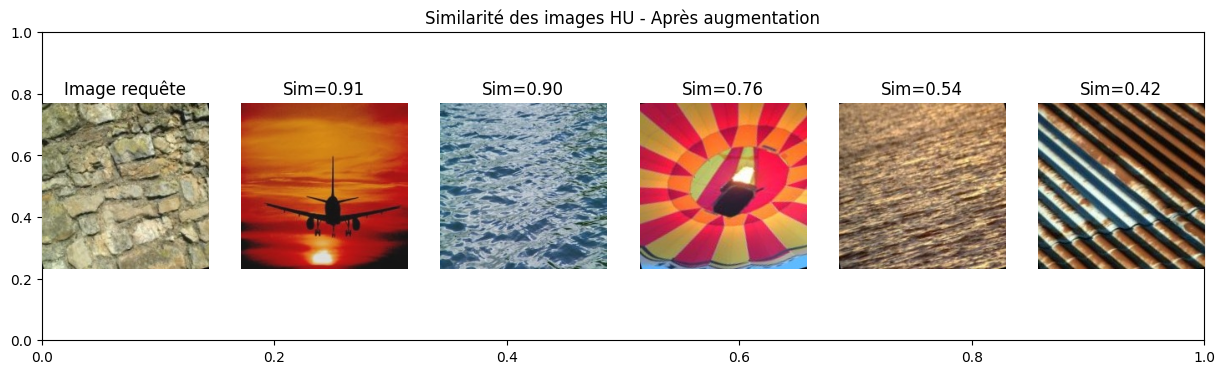

In [30]:
query_index = 0

# before augmentation
S = compute_similarity_matrix(descriptors_images)
P = normalize_similarity_matrix(S)
show_similar_images(P, image_paths, query_index, message="SIFT - Avant augmentation")

S_hu = compute_hu_similarity_matrix(hu_features)
P_hu = normalize_similarity_matrix(S_hu)
show_similar_images(P_hu, image_paths, query_index, message="HU - Avant augmentation")

# after augmetation
show_similar_images(P, augmented_paths, query_index, message="SIFT - Après augmentation")
show_similar_images(P_hu, augmented_paths, query_index, message="HU - Après augmentation")